In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC

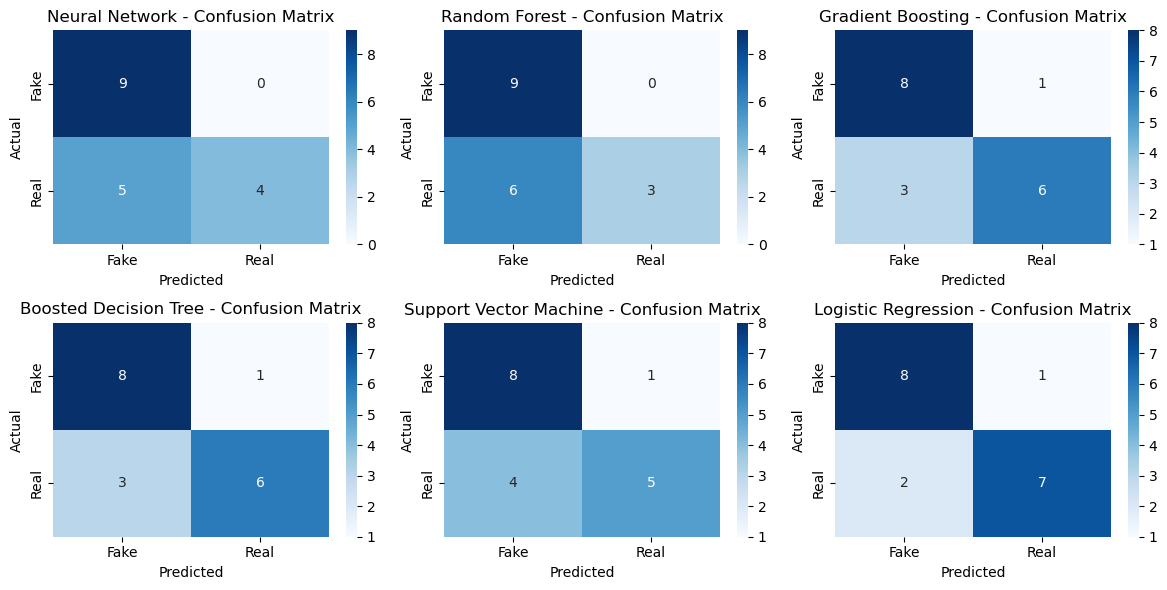

Model Performance:

Neural Network:
  Accuracy = 0.7222
  F1 Score = 0.6990
  AUC Score = 0.8395
  Cross-Validation Score = 0.7417

Random Forest:
  Accuracy = 0.6667
  F1 Score = 0.6250
  AUC Score = 0.9383
  Cross-Validation Score = 0.7694

Gradient Boosting:
  Accuracy = 0.7778
  F1 Score = 0.7750
  AUC Score = 0.7901
  Cross-Validation Score = 0.7167

Boosted Decision Tree:
  Accuracy = 0.7778
  F1 Score = 0.7750
  AUC Score = 0.8395
  Cross-Validation Score = 0.7167

Support Vector Machine:
  Accuracy = 0.7222
  F1 Score = 0.7143
  AUC Score = 0.8395
  Cross-Validation Score = 0.7167

Logistic Regression:
  Accuracy = 0.8333
  F1 Score = 0.8328
  AUC Score = 0.8642
  Cross-Validation Score = 0.7917


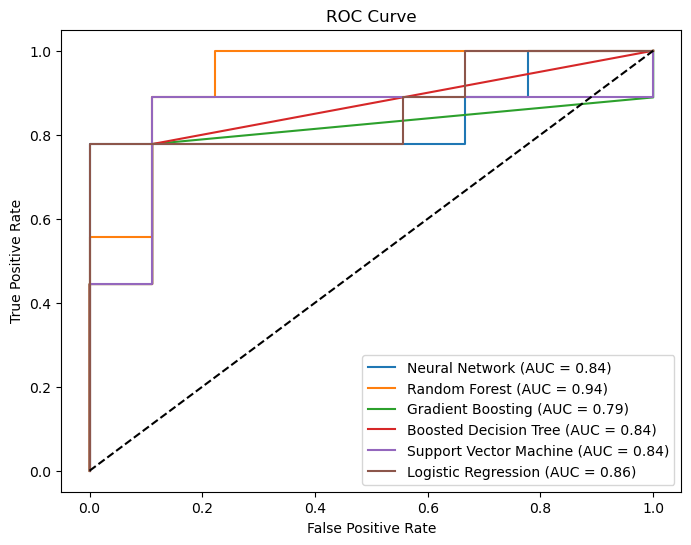

In [17]:
data = pd.read_csv("singfake_bilibili_audio_features.csv")
target = "bonafide_or_spoof"
label_encoder = LabelEncoder()
data[target] = label_encoder.fit_transform(data[target])
numerical_features = ["views", "likes", "comments", "subscribers", 
                      "num_channels", "sample_width", "frame_rate", 
                      "num_frames", "audio_time"]


# Remove non-informative features
data = data.drop(columns=["set", "language", "singer", "title", "url", "user_id", "username"], errors='ignore')

data = data.dropna(subset=numerical_features + [target])

# Log transformation for skewed features
for col in ["views", "likes", "comments", "subscribers"]:
    data[col] = np.log1p(data[col])

constant_filter = VarianceThreshold(threshold=0)
data_filtered = constant_filter.fit_transform(data[numerical_features])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered)
k = min(10, data_scaled.shape[1])
selector = SelectKBest(f_classif, k=k)
X_selected = selector.fit_transform(data_scaled, data[target])
X_train, X_test, y_train, y_test = train_test_split(X_selected, data[target], test_size=0.3, random_state=42, stratify=data[target])

models = {
    "Neural Network": MLPClassifier(hidden_layer_sizes=(256, 128, 64),
                                    max_iter=5000,
                                    learning_rate_init=0.001,
                                    solver="adam",
                                    early_stopping=True,
                                    batch_size=4,
                                    random_state=42),

    "Random Forest": RandomForestClassifier(n_estimators=300,
                                            max_depth=8,
                                            class_weight="balanced",
                                            random_state=42),
    
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=500,
                                                    learning_rate=0.02,
                                                    max_depth=5,
                                                    min_samples_split=3,
                                                    random_state=42),
    
    "Boosted Decision Tree": GradientBoostingClassifier(n_estimators=300,
                                                        learning_rate=0.03,
                                                        max_depth=6,
                                                        min_samples_split=3, 
                                                        random_state=42),

    "Support Vector Machine": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    
    "Logistic Regression": LogisticRegression(class_weight="balanced",  
                                              solver="liblinear",  
                                              max_iter=2000)
}

results = {}
plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(models.items(), start=1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, target_names=["Fake", "Real"], zero_division=1, output_dict=True)["weighted avg"]["f1-score"]
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    results[name] = {"Accuracy": accuracy, "F1 Score": f1, "AUC": auc, "CV Score": cv_score}

    # Confusion Matrix Plot
    plt.subplot(2, 3, i)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Display results
print("Model Performance:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy = {metrics['Accuracy']:.4f}")
    print(f"  F1 Score = {metrics['F1 Score']:.4f}")
    print(f"  AUC Score = {metrics['AUC']:.4f}" if metrics['AUC'] is not None else "  AUC Score = N/A")
    print(f"  Cross-Validation Score = {metrics['CV Score']:.4f}")

# ROC Curve Plot
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['AUC']:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Explanation of the Code
The code performs a machine learning-based classification on the SingFake dataset, aiming to distinguish between bonafide (real) and spoofed (fake) audio. Below is a breakdown of the steps involved:

1. Data Preprocessing
The dataset is loaded from a CSV file.
The target variable (bonafide_or_spoof) is encoded using LabelEncoder so that it can be processed by machine learning models.
Non-informative columns such as metadata (set, language, singer, title, url, user_id, username) are removed.
Missing values in numerical features are dropped.
Log transformation is applied to highly skewed features (views, likes, comments, subscribers) to reduce variance.
Feature filtering: The VarianceThreshold is used to remove constant or low-variance features.
Standardization: All numerical features are scaled using StandardScaler to bring them to a uniform range.
Feature selection: SelectKBest(f_classif) is used to select the top 10 most informative features.
2. Model Training and Evaluation
Train-test split: The dataset is divided into training (70%) and testing (30%) sets, ensuring class balance.

Multiple classification models are trained:

Neural Network
Random Forest
Gradient Boosting
Boosted Decision Tree
Support Vector Machine (SVM)
Logistic Regression
Naïve Bayes (newly added)
Performance Metrics Used:

Accuracy: Measures the percentage of correctly classified samples.
F1 Score: Balances precision and recall, especially useful for imbalanced datasets.
AUC Score: Evaluates how well the model distinguishes between classes.
Cross-Validation Score: Ensures model generalization over different dataset partitions.
Confusion Matrices are plotted for each model to analyze misclassifications.

ROC Curves are generated to visualize model performance in distinguishing real and fake audio.

Analysis of Results
Model	                Accuracy	    F1 Score	   AUC Score	   Cross-Validation Score
Neural Network	         0.7222	         0.6990	         0.8395	               0.7417
Random Forest	         0.6667	         0.6250	         0.9383	               0.7694
Gradient Boosting	     0.7778	         0.7750	         0.7901	               0.7167
Boosted Decision Tree	 0.7778	         0.7750	         0.8395	               0.7167
Support Vector Machine	 0.7222	         0.7143	         0.8395	               0.7167
Logistic Regression	     0.8333	         0.8328	         0.8642	               0.7917
Key Insights
Logistic Regression achieved the highest accuracy (83.33%) and F1 score (83.28%), suggesting that a linear decision boundary might work well for this dataset.
Random Forest had the highest AUC Score (0.9383), meaning it is the best at distinguishing real vs. fake audio in probabilistic terms.
Boosted models (Gradient Boosting & Boosted Decision Tree) performed similarly with accuracy of 77.78% and F1 score of 77.50%, indicating that ensemble methods are effective.
Neural Networks and SVM showed moderate performance (~72% accuracy), which suggests that feature representation might not be complex enough for deep learning.
Random Forest had the highest Cross-Validation Score (76.94%), meaning it generalizes well across different data splits.

In [5]:
!pip install imbalanced-learn
